In [55]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import APIErrorException

from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person
from tqdm import tqdm
import json
import tensorflow as tf
import numpy as np
sys.path.append("../")
from utils import prewhiten, l2_normalize
from attacks.attack import Attacker
from sklearn.metrics import pairwise_distances, roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
seaborn.set()

## Set Up, Load Model, and Images

In [3]:
model_path = '/home/ivan/pascal_adversarial_faces/keras-facenet/model/facenet_keras.h5'

In [4]:
auth_file = "/home/ivan/azure_auth.json"
with open(auth_file, "r") as f:
    auth_data = json.loads(f.read())
face_client = FaceClient(
    auth_data["endpoint"], 
    CognitiveServicesCredentials(auth_data["key"])
)

In [5]:
model = tf.keras.models.load_model(mdodel_path)

In [6]:
def load_image_for_vggface(
    path,
    crop_box,
    resize_size=160,
    prewhiten=False
):
    img = Image.open(path).convert("RGB").crop(crop_box).resize((resize_size, resize_size))
    img = (np.array(img)).astype(np.float32)
    
    if prewhiten:
        img = prewhiten(img)
    
    return img

def load_cropped_images(paths_list):
    final_imgs = []
    for img_path in paths_list:
        results = face_client.face.detect_with_stream(
            open(img_path, "r+b"), 
            detectionModel='detection_02'
        )
        crop_box = (
            results[0].face_rectangle.left,
            results[0].face_rectangle.top,
            results[0].face_rectangle.left + results[0].face_rectangle.width,
            results[0].face_rectangle.top + results[0].face_rectangle.height
        )
        final_imgs.append(load_image_for_vggface(img_path, crop_box))
        
    mean, std = np.mean(final_imgs), np.std(final_imgs)
    final_imgs = prewhiten(np.array(final_imgs))
    return final_imgs, mean, std


In [7]:
yoshi_paths = glob.glob("/data/ivan_yoshi_pascal/yoshi_*")
ivan_paths = glob.glob("/data/ivan_yoshi_pascal/ivan_*")

In [8]:
yoshi_images, yoshi_mean, yoshi_std = load_cropped_images(yoshi_paths)

In [9]:
ivan_images, ivan_mean, ivan_std = load_cropped_images(ivan_paths)

In [10]:
def roc_curve(positive, negative):
    roc_auc = roc_auc_score(
        [1 for x in positive] + [0 for x in negative],
        np.concatenate((positive, negative), axis=0), 
    )
    print(f"Computed ROC AUC: {roc_auc:.3f}")
    
    thresholds = np.arange(1e-6, 2.0, 0.1)
    tprs = []
    fprs = []
    n_pos = float(len(positive))
    n_neg = float(len(negative))

    print("**** Computing ROC curve *****")
    for t in thresholds:
        tp = np.sum(positive < t)
        fp = np.sum(negative < t)
        tprs.append(tp / n_pos)
        fprs.append(fp / n_neg)

    plt.plot(np.arange(0.0, 1.1, 0.1), np.arange(0.0, 1.1, 0.1), label="y=x")
    plt.plot(fprs, tprs, label="ResNet50 VGGFace2")
    plt.legend()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("ROC Curve for model")

In [11]:
def undo_preprocess(images, mean, std):
    restored_images = images.copy()
    restored_images  *= std
    restored_images += mean
    restored_images = np.clip(restored_images, 0.0, 255.0)
    return np.uint8(restored_images)

## Sanity Check Model Loading

In [12]:
def sanity_check(model, ivan_images, yoshi_images):
    yoshi_embeddings = model.predict(np.array(yoshi_images), batch_size=6)
    yoshi_embeddings = l2_normalize(yoshi_embeddings)
    
    ivan_embeddings = model.predict(np.array(ivan_images), batch_size=6)
    ivan_embeddings = l2_normalize(ivan_embeddings)
    
    self_distances = pairwise_distances(
         ivan_embeddings,
         ivan_embeddings,
         metric='euclidean',
         n_jobs=4
    )
    # all distances below the diagonal compare every pair and exclude 0's to self
    self_dist_indices = np.tril_indices(n=len(ivan_embeddings), k=-1)
    # this selection returns a flattened array of distances that are ground truth True
    self_distances = self_distances[self_dist_indices]

    negative_distances = pairwise_distances(
        ivan_embeddings,
        yoshi_embeddings,
        metric='euclidean',
        n_jobs=4
    ).flatten()

    roc_curve(self_distances, negative_distances)
    
    fig1, ax1 = plt.subplots()
    ax1.boxplot([self_distances, negative_distances])

Computed ROC AUC: 0.013
**** Computing ROC curve *****


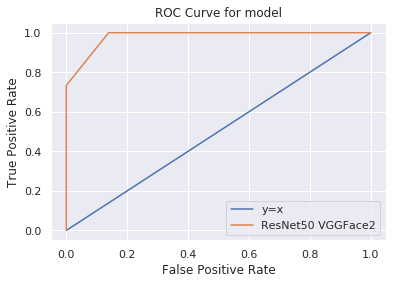

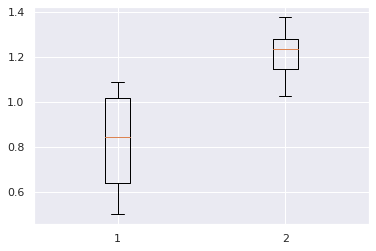

In [13]:
sanity_check(model, ivan_images, yoshi_images)

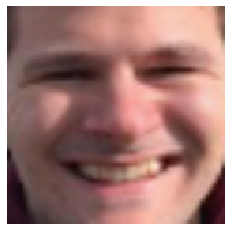

In [14]:
plt.axis('off')
denorm_ivan_img = undo_preprocess(ivan_images[0], ivan_mean, ivan_std)
plt.imshow(denorm_ivan_img)

## Attack Experiments

In [15]:
class PlainAttacker(Attacker):
    def _get_default_kwargs(self, kwargs, image_batch):
        """
        Gets some default values for existing hyper-parameters.
        """
        if 'bounds' not in kwargs:
            kwargs['bounds'] = [tf.reduce_min(image_batch), tf.reduce_max(image_batch)]
        if 'num_iters' not in kwargs:
            kwargs['num_iters'] = 400
        if 'patience' not in kwargs:
            kwargs['patience'] = 5
        if 'alpha' not in kwargs:
            kwargs['alpha'] = 0.001
        if 'verbose' not in kwargs:
            kwargs['verbose'] = False
        return kwargs


    def target_vector_attack(
        self, 
        image_batch, 
        target_embedding, 
        normalize_target_embedding=True, 
        epsilon=0.1, 
        **kwargs
    ):
        """
        Attacks a batch of images using PGD using the
        target-image strategy.
        Args:
            image_batch: A batch of images. The images to perturb.
            target_embedding: the target embeddings to send adversarial images to
            normalize_target_embedding: if True, l2 normalizes the target_embedding
            epsilon: Maximum perturbation amount
            kwargs: Varies depending on attack.
        """
        kwargs = self._get_default_kwargs(kwargs, image_batch)
        image_batch  = tf.convert_to_tensor(image_batch.copy())
        target_embedding = tf.convert_to_tensor(target_embedding, dtype=tf.float32)
        
        if normalize_target_embedding:
            target_embedding = self._l2_normalize(target_embedding)
        
        perturbed_image_batch = image_batch

        previous_difference = np.inf
        best_perturbation = perturbed_image_batch
        patience_count = 0

        iterable = range(kwargs['num_iters'])
        if kwargs['verbose']:
            iterable = tqdm(iterable)
        
        self.losses = []
        for i in iterable:
            with tf.GradientTape() as tape:
                tape.watch(perturbed_image_batch)
                
                batch_embedding = self.model(perturbed_image_batch)
        
                batch_embedding = self._l2_normalize(batch_embedding)
            
                difference = self._l2_distance(target_embedding, batch_embedding)
                mean_difference = tf.reduce_mean(difference)
                
                self.losses.append(mean_difference)
                
            if mean_difference < previous_difference:
                previous_difference = mean_difference
                best_perturbation = perturbed_image_batch
                patience_counnt = 0
            elif patience_count >= kwargs['patience']:
                break
            else:
                patience_count += 1

            gradient = tape.gradient(difference, perturbed_image_batch)
            sign_of_gradient = tf.cast(tf.sign(gradient), perturbed_image_batch.dtype)

            # Subtract the gradient because we want to minimize the distance
            perturbed_image_batch = perturbed_image_batch - sign_of_gradient * kwargs['alpha']
            perturbed_image_batch = tf.clip_by_value(perturbed_image_batch, image_batch - epsilon, image_batch + epsilon)
            perturbed_image_batch = tf.clip_by_value(perturbed_image_batch, kwargs['bounds'][0], kwargs['bounds'][1])

        return best_perturbation

In [16]:
class ExperimentalAttacker(Attacker):
    def _get_default_kwargs(self, kwargs, image_batch):
        """
        Gets some default values for existing hyper-parameters.
        """
        if 'bounds' not in kwargs:
            kwargs['bounds'] = [tf.reduce_min(image_batch), tf.reduce_max(image_batch)]
        if 'num_iters' not in kwargs:
            kwargs['num_iters'] = 400
        if 'patience' not in kwargs:
            kwargs['patience'] = 5
        if 'alpha' not in kwargs:
            kwargs['alpha'] = 0.001
        if 'verbose' not in kwargs:
            kwargs['verbose'] = False
        return kwargs


    def target_vector_attack(
        self, 
        image_batch, 
        target_embedding, 
        normalize_target_embedding=True, 
        epsilon=0.1, 
        **kwargs
    ):
        """
        Attacks a batch of images using PGD using the
        target-image strategy.
        Args:
            image_batch: A batch of images. The images to perturb.
            target_embedding: the target embeddings to send adversarial images to
            normalize_target_embedding: if True, l2 normalizes the target_embedding
            epsilon: Maximum perturbation amount
            kwargs: Varies depending on attack.
        """
        kwargs = self._get_default_kwargs(kwargs, image_batch)
        image_batch  = tf.convert_to_tensor(image_batch.copy())
        target_embedding = tf.convert_to_tensor(target_embedding, dtype=tf.float32)
        
        if normalize_target_embedding:
            target_embedding = self._l2_normalize(target_embedding)
        
        perturbed_image_batch = image_batch

        previous_difference = np.inf
        best_perturbation = perturbed_image_batch
        patience_count = 0

        iterable = range(kwargs['num_iters'])
        if kwargs['verbose']:
            iterable = tqdm(iterable)
        
        self.losses = []
        for i in iterable:
            with tf.GradientTape() as tape:
                tape.watch(perturbed_image_batch)
                
                if i < kwargs['iters_no_rand']:
                    batch_input_to_model = perturbed_image_batch
                else:
                    batch_input_to_model = tf.image.random_flip_left_right(perturbed_image_batch)
                    batch_input_to_model = tf.image.random_brightness(batch_input_to_model, max_delta=0.25)
    #                 batch_input_to_model = tf.image.random_jpeg_quality(batch_input_to_model, 5, 90)

                    batch_input_to_model += tf.random.normal(batch_input_to_model.shape, 0.0, 0.5)
    
                batch_embedding = self.model(batch_input_to_model)
        
                batch_embedding = self._l2_normalize(batch_embedding)
            
                difference = self._l2_distance(target_embedding, batch_embedding)
                mean_difference = tf.reduce_mean(difference)
                
                self.losses.append(mean_difference)
                
            if mean_difference < previous_difference:
                previous_difference = mean_difference
                best_perturbation = perturbed_image_batch

            gradient = tape.gradient(difference, perturbed_image_batch)
            sign_of_gradient = tf.cast(tf.sign(gradient), perturbed_image_batch.dtype)

            # Subtract the gradient because we want to minimize the distance
            perturbed_image_batch = perturbed_image_batch - sign_of_gradient * kwargs['alpha']
            perturbed_image_batch = tf.clip_by_value(perturbed_image_batch, image_batch - epsilon, image_batch + epsilon)
            perturbed_image_batch = tf.clip_by_value(perturbed_image_batch, kwargs['bounds'][0], kwargs['bounds'][1])

        return best_perturbation

In [24]:
yoshi_embeddings = model.predict(np.array(yoshi_images), batch_size=6)
ivan_embeddings = model.predict(np.array(ivan_images), batch_size=6)

In [18]:
def run_attack(
    attacker, 
    num_iters=600,
    epsilon=0.25,
    iters_no_rand=10,
    alpha=0.1,
):
    ivan_adversarial_img = attacker.target_vector_attack(
        ivan_images[0:1], 
        yoshi_embeddings[0:1],
        normalize_target_embedding=True, 
        num_iters=num_iters,
        epsilon=epsilon,
        iters_no_rand=iters_no_rand,
        alpha=alpha
    )
    denorm_ivan_adversarial_img = undo_preprocess(np.array(ivan_adversarial_img[0]), ivan_mean, ivan_std)
    
    ax1 = plt.subplot(1, 1, 1)
    ax1.axis("off")
    ax1.imshow(denorm_ivan_adversarial_img)
    plt.show()
    
    ax2 = plt.subplot(1, 1, 1)
    ax2.plot(range(len(attacker.losses)), attacker.losses)
    plt.show()
    
    diff = undo_preprocess(np.abs(np.array(ivan_images[0]) - np.array(ivan_adversarial_img[0])), ivan_mean, ivan_std)
    ax3 = plt.subplot(1, 1, 1)
    ax3.axis("off")
    ax3.imshow(diff)
    plt.show()
    
    ivan_adversarial_embedding = model(ivan_adversarial_img)
    ivan_original_embedding = model(ivan_images[0:1])
    
    ivan_adv_yoshi = pairwise_distances(
        ivan_adversarial_embedding,
        yoshi_embeddings[0:1],
        metric='euclidean',
    )[0][0]
    
    ivan_clean_yoshi = pairwise_distances(
        ivan_original_embedding,
        yoshi_embeddings[0:1],
        metric='euclidean',
    )[0][0]
    
    print(f"Distance ivan adv <-> yoshi {ivan_adv_yoshi:.3f}")
    print(f"Distance ivan clean <-> yoshi {ivan_clean_yoshi:.3f}")
    
    Image.fromarray(denorm_ivan_adversarial_img).save("/tmp/ivan_adv.jpeg")
    reloaded_img = prewhiten(np.array(Image.open("/tmp/ivan_adv.jpeg")).astype(np.float32))
    reloaded_embedding = model(np.expand_dims(reloaded_img, axis=0))

    reloaded_yoshi = pairwise_distances(
        reloaded_embedding,
        yoshi_embeddings[0:1],
        metric='euclidean',
    )[0][0]
    print(f"Distance ivan reloaded <-> yoshi {reloaded_yoshi:.3f}")

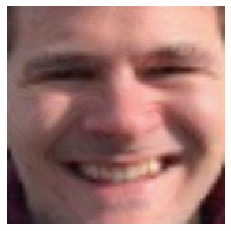

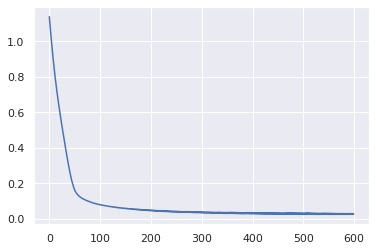

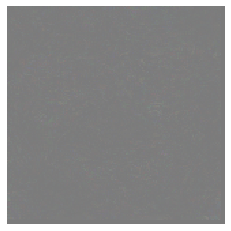

Distance ivan adv <-> yoshi 0.302
Distance ivan clean <-> yoshi 13.858
Distance ivan reloaded <-> yoshi 4.868


In [21]:
run_attack(PlainAttacker(model))

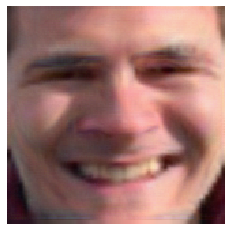

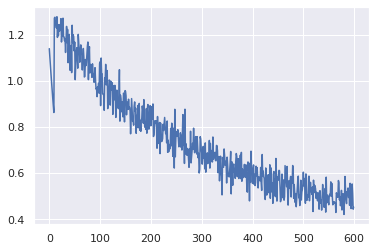

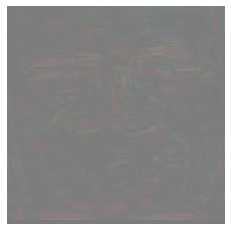

Distance ivan adv <-> yoshi 5.446
Distance ivan clean <-> yoshi 13.858
Distance ivan reloaded <-> yoshi 5.689


In [26]:
run_attack(ExperimentalAttacker(model))

## Quick Hyperparameter Sweep

In [27]:
def run_with_kwargs(**kwargs):
    attacker = ExperimentalAttacker(model)
    ivan_adversarial_img = attacker.target_vector_attack(
        ivan_images[0:1], 
        yoshi_embeddings[0:1],
        normalize_target_embedding=True, 
        **kwargs
    )
    
    ivan_adversarial_embedding = model(ivan_adversarial_img)
    
    ivan_adv_yoshi = pairwise_distances(
        ivan_adversarial_embedding,
        yoshi_embeddings[0:1],
        metric='euclidean',
    )[0][0]
    return ivan_adv_yoshi

In [28]:
class Results:
    pass

all_results = []
for alpha in [1.0, 0.5, 0.1, 0.01, 0.001, 0.0001]:
    for num_iters in [100, 500, 1000, 2000]:
        final_dist = run_with_kwargs(alpha=alpha, num_iters=num_iters, iters_no_rand=0)
        res = Results()
        res.alpha = alpha
        res.num_iters = num_iters
        res.final_dist = final_dist
        all_results.append(res)

In [30]:
sorted_results = sorted(all_results, key=lambda x: x.final_dist)

In [34]:
for sr in sorted_results:
    print(sr.final_dist, sr.alpha, sr.num_iters)

5.984836 0.001 2000
6.0660396 0.01 500
6.1402993 0.01 1000
6.1953654 0.001 1000
6.432452 0.01 2000
6.6226625 0.001 500
7.192639 0.01 100
8.300171 0.0001 2000
9.568829 0.1 2000
9.67125 0.1 1000
9.769838 0.1 500
10.207621 0.5 500
10.285359 0.0001 1000
10.486581 0.1 100
10.588236 0.5 2000
10.737666 1.0 2000
10.993639 0.001 100
11.080485 0.5 1000
11.255797 1.0 1000
11.5435295 1.0 500
11.598961 1.0 100
11.733939 0.5 100
12.204535 0.0001 500
13.542383 0.0001 100


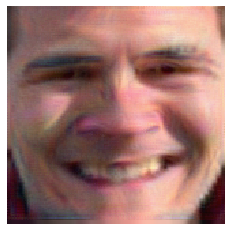

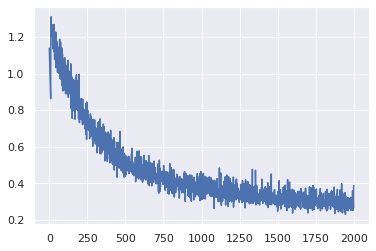

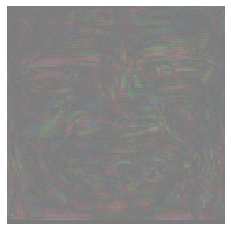

Distance ivan adv <-> yoshi 4.501
Distance ivan clean <-> yoshi 13.858
Distance ivan reloaded <-> yoshi 4.303


In [19]:
run_attack(
    ExperimentalAttacker(model),
    epsilon=0.5, 
    num_iters=2000,
    alpha=0.001,
    iters_no_rand=10
)

In [25]:
yoshi_mean_embedding = np.expand_dims(np.mean(yoshi_embeddings, axis=0), 0)
ivan_mean_embedding = np.expand_dims(np.mean(ivan_embeddings, axis=0), 0)

print(yoshi_mean_embedding.shape)
print(ivan_mean_embedding.shape)

(1, 128)
(1, 128)


In [26]:
attacker = ExperimentalAttacker(model)
print("Attacking Ivan's images")
ivan_adversarial_images = attacker.target_vector_attack(
    ivan_images, 
    yoshi_mean_embedding,
    normalize_target_embedding=True, 
    num_iters=2000,
    epsilon=0.5,
    iters_no_rand=10,
    alpha=0.001
)

print("Attacking Yoshi's images")
yoshi_adversarial_images = attacker.target_vector_attack(
    yoshi_images, 
    ivan_mean_embedding,
    normalize_target_embedding=True, 
    num_iters=2000,
    epsilon=0.5,
    iters_no_rand=10,
    alpha=0.001
)

Attacking Ivan's images
Attacking Yoshi's images


In [27]:
yoshi_adversarial_embeddings = model.predict(np.array(yoshi_adversarial_images), batch_size=6)
ivan_adversarial_embeddings = model.predict(np.array(ivan_adversarial_images), batch_size=6)

In [37]:
def mega_plot(
    ivan_embeddings,
    yoshi_embeddings, 
    ivan_adversarial_embeddings,
    yoshi_adversarial_embeddings
):
    ivan_clean_adv = pairwise_distances(
         ivan_embeddings,
         ivan_adversarial_embeddings,
         metric='euclidean',
    ).flatten()
    yoshi_clean_adv = pairwise_distances(
         yoshi_embeddings,
         yoshi_adversarial_embeddings,
         metric='euclidean',
    ).flatten()
    ivan_yoshi_clean = pairwise_distances(
         ivan_embeddings,
         yoshi_embeddings,
         metric='euclidean',
    ).flatten()
    ivan_adv_yoshi_adv =  pairwise_distances(
         ivan_adversarial_embeddings,
         yoshi_adversarial_embeddings,
         metric='euclidean',
    ).flatten()


    ivan_clean_clean = pairwise_distances(
         ivan_embeddings,
         ivan_embeddings,
         metric='euclidean',
    )[np.tril_indices(len(ivan_embeddings), k=-1)]

    yoshi_clean_clean = pairwise_distances(
         yoshi_embeddings,
         yoshi_embeddings,
         metric='euclidean',
    )[np.tril_indices(len(yoshi_embeddings), k=-1)]

    ivan_adv_yoshi_clean = pairwise_distances(
         ivan_adversarial_embeddings,
         yoshi_embeddings,
         metric='euclidean',
    ).flatten()
    yoshi_adv_ivan_clean = pairwise_distances(
         yoshi_adversarial_embeddings,
         ivan_embeddings,
         metric='euclidean',
    ).flatten()

    fig1, ax1 = plt.subplots(figsize=(10, 10))
    ax1.boxplot([ivan_clean_adv, yoshi_clean_adv, 
                 ivan_yoshi_clean, ivan_adv_yoshi_adv, 
                 yoshi_clean_clean, ivan_clean_clean,
                ivan_adv_yoshi_clean, yoshi_adv_ivan_clean
                ])
    ax1.set_xticklabels(["ivan clean <-> ivan adversarial", "yoshi clean <-> yoshi adversarial",
                        "ivan clean <-> yoshi clean", "ivan adversarial <-> yoshi adversarial",
                        "ivan clean <-> ivan clean", "yoshi clean <-> yoshi clean",
                        "ivan adversarial <-> yoshi clean", "yoshi adversarial <-> ivan clean"],
                       rotation=45, fontsize=12)


In [43]:
def save_array(imgs_arr, mean, std, folder, name, form="png"):
    imgs_arr = np.array(imgs_arr)
    for indx, img in enumerate(imgs_arr):
        Image.fromarray(undo_preprocess(img, ivan_mean, ivan_std)).save(
            os.path.join(folder, f"{name}_{indx:02d}.{form}")
        )

def load_folder_no_crop(folder, prefix=None):
    if prefix:
        filenames = glob.glob(os.path.join(folder, prefix + "*"))
    else:
        filenames = glob.glob(folder + "*")
    
    final = []
    for file in filenames:
        im = Image.open(file).convert("RGB")
        final.append(prewhiten(np.array(im)))
    return np.array(final)

In [46]:
save_array(ivan_adversarial_images, ivan_mean, ivan_std, "/home/ivan/ivan_yoshi_adversarial_faces", "ivan", "jpeg")
save_array(yoshi_adversarial_images, yoshi_mean, yoshi_std, "/home/ivan/ivan_yoshi_adversarial_faces", "yoshi", "jpeg")

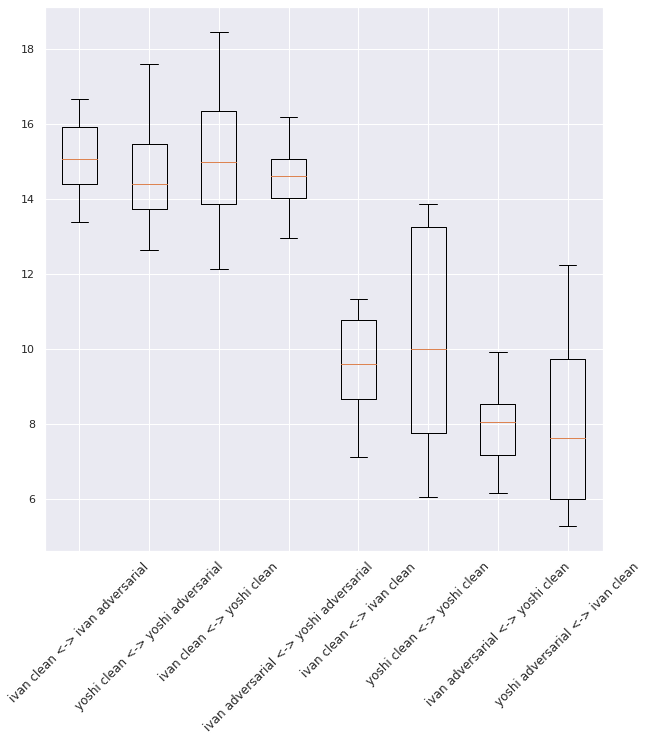

In [47]:
ivan_reloaded_adversarial_images = load_folder_no_crop("/home/ivan/ivan_yoshi_adversarial_faces", "ivan")
yoshi_reloaded_adversarial_images = load_folder_no_crop("/home/ivan/ivan_yoshi_adversarial_faces", "yoshi")

ivan_reloaded_adversarial_embeddings = model.predict(np.array(ivan_reloaded_adversarial_images), batch_size=6)
yoshi_reloaded_adversarial_embeddings = model.predict(np.array(yoshi_reloaded_adversarial_images), batch_size=6)

mega_plot(ivan_embeddings, yoshi_embeddings, ivan_reloaded_adversarial_embeddings, yoshi_reloaded_adversarial_embeddings)

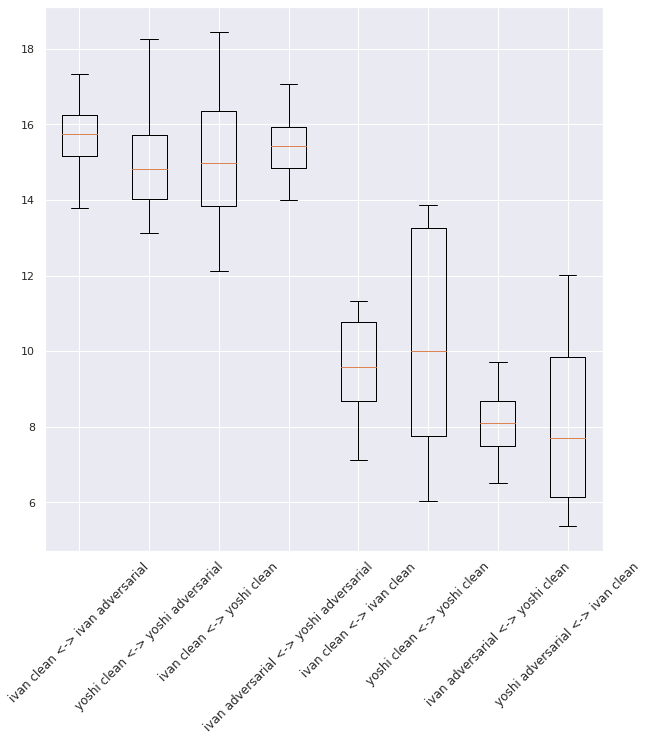

In [50]:
mega_plot(
    ivan_embeddings, 
    yoshi_embeddings, 
    ivan_adversarial_embeddings, 
    yoshi_adversarial_embeddings)

## Test on Azure

In [51]:
class PersonGroupExistsError(ValueError):
    pass


class PersonGroupInterface:
    def __init__(self, person_group_name, endpoint, key):
        self.face_client = FaceClient(
            endpoint, CognitiveServicesCredentials(key))
        self.person_group_name = person_group_name
        self._verify_person_group_does_not_exist(person_group_name)
        self.name_to_person_obj = {}
        self.face_client.person_group.create(
            person_group_id=self.person_group_name,
            name=self.person_group_name
        )

    def _verify_person_group_does_not_exist(self, person_group_name):
        # Check if person group exists on Azure instance
        existing_pg = self.face_client.person_group.list()
        for gr in existing_pg:
            if gr.name == person_group_name or gr.person_group_id == person_group_name:
                raise PersonGroupExistsError(
                    f"Group {person_group_name} already exists; please delete or fix accordingly"
                )

    def create_person_for_each_identity(self, identities):
        for person_name in identities:
            self.name_to_person_obj[person_name] = self.face_client.person_group_person.create(
                self.person_group_name, person_name
            )

    def _add_folder(self, folder_path, person_name):
        # List all jpeg, jpg and png images
        # glob returns full paths
        file_paths = [fn for fn in glob.glob(
            os.path.join(folder_path, person_name + '*')
        ) if fn.endswith("png") or fn.endswith("jpg") or fn.endswith("jpeg")]

        print(f"Adding folder {folder_path}")
        # Add to Azure instance
        for img_path in tqdm(file_paths):
            try:
                self.face_client.person_group_person.add_face_from_stream(
                    self.person_group_name,
                    self.name_to_person_obj[person_name].person_id,
                    open(img_path, "r+b")
                )
            except APIErrorException as e:
                print(f"Exception {e} for image {img_path}")
            # Sleep to avoid triggering rate limiters
            time.sleep(10)

    def add_images(
            self, image_directory, people_names):
       
        for person in people_names:
            self._add_folder(image_directory, person)


    def train(self):
        print()
        print('Training the person group...')
        # Train the person group
        self.face_client.person_group.train(self.person_group_name)

        while (True):
            training_status = self.face_client.person_group.get_training_status(self.person_group_name)
            print("Training status: {}.".format(training_status.status))
            print()
            if (training_status.status is TrainingStatusType.succeeded):
                break
            elif (training_status.status is TrainingStatusType.failed):
                sys.exit('Training the person group has failed.')
            time.sleep(5)

In [60]:
pgi = PersonGroupInterface("ivan_yoshi_strong_attack", endpoint=auth_data["endpoint"], key=auth_data["key"])
pgi.create_person_for_each_identity(["yoshi", "ivan"])
pgi.add_images("/home/ivan/ivan_yoshi_adversarial_faces", ["yoshi", "ivan"])

  0%|          | 0/6 [00:00<?, ?it/s]

Adding folder /home/ivan/ivan_yoshi_adversarial_faces


  0%|          | 0/6 [00:00<?, ?it/s]

Adding folder /home/ivan/ivan_yoshi_adversarial_faces


 67%|██████▋   | 4/6 [00:41<00:20, 10.27s/it]

Exception (InvalidImage) No face detected in the image. for image /home/ivan/ivan_yoshi_adversarial_faces/ivan_04.jpeg


100%|██████████| 6/6 [01:01<00:00, 10.23s/it]


In [59]:
# face_client.person_group.delete(person_group_id="ivan_yoshi_strong_attack")

In [70]:
pgi.train()


Training the person group...
Training status: running.

Training status: succeeded.



In [83]:
def get_discovery_for_identities(person_id_to_name, folder_path, person_group_name):
    discovery = []
    identities = person_id_to_name.values()
    
    for identity in tqdm(identities):  
        query_photos_paths = glob.glob(os.path.join(folder_path, identity + "*"))
        
        for path in query_photos_paths:
            faces_in_query_photos = face_client.face.detect_with_stream(
                open(path, "r+b"), 
                detectionModel='detection_02'
            )
            if len(faces_in_query_photos) > 1:
                print(f"Found more than one faces {len(faces_in_query_photos)}")
                break


            # There should only be one face, so we use that as the query face.
            results = face_client.face.identify(
                [faces_in_query_photos[0].face_id],
                person_group_name
            )

            if len(results) < 1 or len(results[0].candidates) < 1:
                discovery.append(1.0)

            else: 
                top_identity = person_id_to_name[results[0].candidates[0].person_id]
                confidence = results[0].candidates[0].confidence
                print(f"Top identity for image {path} is {top_identity} with confidence {confidence:.3f}")
                # Note the switch of the term protector here:
                # protectors are also protected but we call them protectors because of the folder structure
                # In this case, the query photo belongs to the protector -- who is also protected by decoys 
                # of *other* protectors. Therefore, if the identity returned is that of the "protector,"
                # this is a failure in the defense.
                if top_identity == identity:
                    discovery.append(1.0)
                else:
                    discovery.append(0.0)

            time.sleep(10)
        
    return sum(discovery)/len(discovery)

In [84]:
reverse_person_id_to_name = {pgi.name_to_person_obj[p].person_id: p for p in pgi.name_to_person_obj.keys()}
print(reverse_person_id_to_name)

{'14f51144-d41d-4e49-a3b1-74aed4c3608a': 'yoshi', 'fdfd2160-02b4-423d-bbfc-5cb389ba11d5': 'ivan'}


In [85]:
print(get_discovery_for_identities(
    reverse_person_id_to_name,
    "/data/ivan_yoshi_pascal",
    "ivan_yoshi_strong_attack"
))

  0%|          | 0/2 [00:00<?, ?it/s]

Top identity for image /data/ivan_yoshi_pascal/yoshi_4.jpg is yoshi with confidence 0.628
Top identity for image /data/ivan_yoshi_pascal/yoshi_1.png is yoshi with confidence 0.564
Top identity for image /data/ivan_yoshi_pascal/yoshi_2.jpg is ivan with confidence 0.625
Top identity for image /data/ivan_yoshi_pascal/yoshi_6.jpeg is yoshi with confidence 0.527
Top identity for image /data/ivan_yoshi_pascal/yoshi_5.jpg is ivan with confidence 0.587
Top identity for image /data/ivan_yoshi_pascal/yoshi_3.jpg is ivan with confidence 0.603


 50%|█████     | 1/2 [01:02<01:02, 62.43s/it]

Top identity for image /data/ivan_yoshi_pascal/ivan_4.png is ivan with confidence 0.555
Top identity for image /data/ivan_yoshi_pascal/ivan_3.jpeg is yoshi with confidence 0.640
Top identity for image /data/ivan_yoshi_pascal/ivan_6.png is yoshi with confidence 0.637
Top identity for image /data/ivan_yoshi_pascal/ivan_5.png is ivan with confidence 0.590


100%|██████████| 2/2 [02:04<00:00, 62.03s/it]

0.5833333333333334
